In [1]:
import numpy as np
import pandas as pd
import pickle
import random

## Tic Tac Toe Game

In [2]:
class TicTacToe:
    def __init__(self, pl1, pl2):
        self.board = np.zeros((3, 3))
        self.pl1 = pl1
        self.pl2 = pl2
        self.isEnd = False
        self.boardReshaped = None
        self.whoStarted = None
        
    
    def whoStarts(self):
        """
        Function which decide which player goes first
        """
        turn = np.random.randint(0, 2, size=1)
        if turn:
            self.playerSymbol = 1
            self.whoStarted = 1
        else:
            self.playerSymbol = -1
            self.whoStarted = -1
        return self.playerSymbol
    

    def winner(self):
        """
        Function that checks which player won
        """
        # row
        for i in range(3):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        
        # col
        for i in range(3):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(3)])
        diag_sum2 = sum([self.board[i, 2 - i] for i in range(3)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        
        # not end
        self.isEnd = False
        return None
    

    def availablePositions(self):
        """
        Check available Positions on board
        """
        positions = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    positions.append((i, j))
        return positions
    

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch player
        if self.playerSymbol == 1:
            self.playerSymbol = -1
        else:
             self.playerSymbol = 1

    def giveReward(self):
        """
        Give Reward when game ends
        """
        result = self.winner()

        if result == 1:
            self.pl1.feedReward(1)
            self.pl2.feedReward(0)
        elif result == -1:
            self.pl1.feedReward(0)
            self.pl2.feedReward(1)
        else:
            if self.whoStarted == 1:
                self.pl1.feedReward(0.4)
                self.pl2.feedReward(0.6)
            else:
                self.pl1.feedReward(0.6)
                self.pl2.feedReward(0.4)
                

    def reset(self):
        """
        Board Reset
        """
        self.board = np.zeros((3, 3))
        self.boardReshaped = None
        self.isEnd = False
        self.whoStarted = None
        

    def play(self, rounds=1, verbose = False):
        """ 
        Fucnion which play and train computer players during n rounds  
        
        """
        n_win = 0
        n_loses = 0
        n_tie = 0
        graph_data = pd.DataFrame()
        out = ''
        
        for i in range(rounds):
            self.whoStarts()
            n_move = 1
            if i % 1000 == 0 and i!= 0:
                print(f'Games  {i}')

            while not self.isEnd:
                if self.playerSymbol == 1:  # Player 1
                    positions = self.availablePositions()
                    pl1_action = self.pl1.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(pl1_action)
                    board_reshaped = str(self.board.reshape(9))
                    self.pl1.states.append(board_reshaped)

                else:
                    # Player 2
                    positions = self.availablePositions()
                    pl2_action = self.pl2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(pl2_action)
                    board_reshaped = str(self.board.reshape(9))
                    self.pl2.states.append(board_reshaped)
                    
                win = self.winner() 
                n_move += 1
                if verbose:
                    if n_move % 2 == 0:
                        print(f'Round {int(n_move/2)}')
                    self.showBoard()
                   
                if win is not None:
                    graph_data = graph_data.append({"n_games":i, "result":win},ignore_index=True)
                    if win == 1:
                        n_win += 1
                        out = self.pl1.name + " wins!"
                    elif win == -1:
                        n_loses += 1
                        out = self.pl2.name + " wins!"
                    elif win == 0:
                        n_tie += 1
                        out = "It's a draw!"
                    if verbose:
                        print(out)
                    self.giveReward()
                    self.pl1.reset()
                    self.pl2.reset()
                    self.reset()
                    break                   
                    
        return n_win, n_loses, n_tie, graph_data
                        
                        
    def showBoard(self):
        # pl1: x ------ pl2: o
        for i in range(0, 3):
            print('-------------')
            out = '| '
            for j in range(0, 3):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------\n')


## Definition of Player who Learns

In [3]:
class computerPlayer:
    def __init__(self, name, e_greedy_rate = 0.1, learn_rate = 0.2):
        self.name = name
        self.lr = learn_rate
        self.e_greedy_rate = e_greedy_rate # tradeoff between exploration-exploitation 
        self.states = []  # record all positions taken
        self.states_value = {}  # state -> score of state

    def chooseAction(self, positions, current_board, symbol):
        value_max = -1
        if np.random.uniform(0, 1) <= self.e_greedy_rate:
            # take random action - exploration
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            for p in positions:
                # choose option which seems the best - exploitation
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardReshaped = str(next_board.reshape(9))
                if self.states_value.get(next_boardReshaped) is None:
                    value = 0 
                else:
                    value = self.states_value.get(next_boardReshaped)
                if value >= value_max:
                    value_max = value
                    action = p
        return action

    def feedReward(self, reward):
        """
        At the end of game, backpropagate and update states value
        """
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def saveKnowledge(self, extension = ''):
        fw = open('Knowledge_' + str(self.name)+ extension, 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadKnowledge(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

## Definition of Static Player, who does not learn

In [4]:
class staticPlayer:
    # playes who knows some rules, but no evolve 
    def __init__(self, name):
        self.name = name
        self.states = []

    def chooseAction(self, positions, current_board, symbol):
        if winning_move_check(current_board, positions, symbol) != None:
            action = winning_move_check(current_board, positions, symbol)
        elif block_move_check(current_board, positions, symbol) != None:
            action =  block_move_check(current_board, positions, symbol)
        elif second_move_check(current_board, positions, symbol) != None:
            action =  second_move_check(current_board, positions, symbol)
        else:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        return action

    def feedReward(self, reward):
        pass

    def reset(self):
        pass

Rules of Static Player: 
   - 1st - if it can win in one move, the player will choose that move
   - 2nd - if the opponent can win in move, the player will block that move
   - 3rd - if the player can choose one position in a way that will be with a possible combination of win in next move, it will choose that move
   - 4rd - otherwise, it will play random

In [5]:
# Rules
def winning_move_check(current_board, positions, Symbol):
    """
    Function to identify coordinates that will result in a winning board state
    """
    for position in positions:
        current_board_copy = current_board.copy()
        current_board_copy[position] = Symbol
        # check for a win along rows
        for i in range(current_board_copy.shape[0]):
            if 0 not in current_board_copy[i, :] and len(set(current_board_copy[i, :])) == 1:
                return position
        # check for a win along columns
        for j in range(current_board_copy.shape[1]):
            if 0 not in current_board_copy[:, j] and len(set(current_board_copy[:, j])) == 1:
                return position
        # check for a win in the diagonals
        if 0 not in np.diag(current_board_copy) and len(set(np.diag(current_board_copy))) == 1:
            return position
        if 0 not in np.diag(np.fliplr(current_board_copy)) and len(set(np.diag(np.fliplr(current_board_copy)))) == 1:
            return position
        
def block_move_check(current_board, positions, Symbol):
    """
    Function to  identify coordinates that will prevent the player 1 from winning
    """
    for position in positions:
        current_board_copy = current_board.copy()
        current_board_copy[position] = Symbol
        # check for a win along rows
        for i in range(current_board_copy.shape[0]):
            if 0 not in current_board_copy[i, :] and (current_board_copy[i, :] == 1).sum() == 2:
                if not (0 not in current_board[i, :] and (current_board[i, :] == 1).sum() == 2):
                    return position
        # check for a win along cols
        for j in range(current_board_copy.shape[1]):
            if 0 not in current_board_copy[:, j] and (current_board_copy[:, j] == 1).sum() == 2:
                if not (0 not in current_board[:, j] and (current_board[:, j] == 1).sum() == 2):
                    return position
        # check for a win in the diagonals
        if 0 not in np.diag(current_board_copy) and (np.diag(current_board_copy) == 1).sum() == 2:
            if not (0 not in np.diag(current_board) and (np.diag(current_board) == 1).sum() == 2):
                return position
        if 0 not in np.diag(np.fliplr(current_board_copy)) and (
                np.diag(np.fliplr(current_board_copy)) == 1).sum() == 2:
            if not (0 not in np.diag(np.fliplr(current_board)) and (
                    np.diag(np.fliplr(current_board)) == 1).sum() == 2):
                return position
            
def second_move_check(current_board, positions, Symbol):
    """
    Function ehich identify coordinates that will result in a row having two 0's and no 1's
    """
    for position in positions:
        current_board_copy = current_board.copy()
        current_board_copy[position] = Symbol
        for i in range(current_board_copy.shape[0]):
            if 1 not in current_board_copy[i, :] and (current_board_copy[i, :] == -1).sum() == 2:
                if not (1 not in current_board[i, :] and (current_board[i, :] == -1).sum() == 2):
                    return position
        for j in range(current_board_copy.shape[1]):
            if 1 not in current_board_copy[:, j] and (current_board_copy[:, j] == -1).sum() == 2:
                if not (1 not in current_board[:, j] and (current_board[:, j] == -1).sum() == 2):
                    return position
        if 1 not in np.diag(current_board_copy) and (np.diag(current_board_copy) == -1).sum() == 2:
            if not (1 not in np.diag(current_board) and (np.diag(current_board) == -1).sum() == 2):
                return position
        if 1 not in np.diag(np.fliplr(current_board_copy)) and (np.diag(np.fliplr(current_board_copy)) == -1).sum() == 2:
            if not (1 not in np.diag(np.fliplr(current_board)) and (np.diag(np.fliplr(current_board)) == -1).sum() == 2):
                return position

## Definition of Human Player

In [6]:
class humanPlayer:
    def __init__(self, name):
        self.name = name
        self.states = []

    def chooseAction(self, positions, board, playerSymbol):
        while True:
            row = int(input("Choose a row:"))
            col = int(input("Choose a column:"))
            action = (row, col)
            if action in positions:
                return action

    def feedReward(self, reward):
        pass

    def reset(self):
        self.states = []
        pass

## Training model

In [16]:
pl1 = computerPlayer('pl1')
# pl2 = computerPlayer('pl2')
pl2 = staticPlayer('pl2')
game = TicTacToe(pl1, pl2)

In [17]:
print("training...")
n_games = 10000
win, lose, tie, data = game.play(n_games,verbose=False)
print("Completed!")

print(f'Player 1 won {win} out of {n_games} games (win rate = {round((win/n_games) * 100, 2)}%)')
print(f'Player 1 lose {lose} out of {n_games} games (lose rate = {round((lose/n_games) * 100, 2)}%)')
print(f'Player 1 drew {tie} out of {n_games} games (tie rate = {round((tie/n_games) * 100, 2)}%)')

training...
Games  1000
Games  2000
Games  3000
Games  4000
Games  5000
Games  6000
Games  7000
Games  8000
Games  9000
Completed!
Player 1 won 3391 out of 10000 games (win rate = 33.91%)
Player 1 lose 4687 out of 10000 games (lose rate = 46.87%)
Player 1 drew 1922 out of 10000 games (tie rate = 19.22%)


Text(0.5, 1.0, 'Results Distribution Vs Games Played')

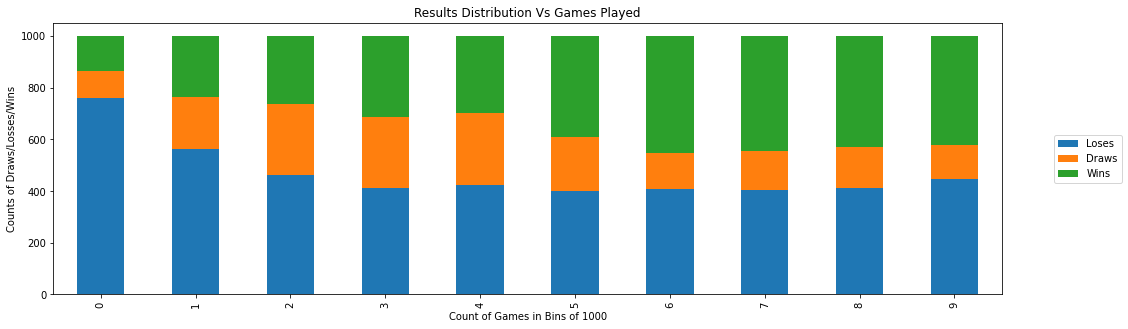

In [20]:
bins = np.arange(1, n_games/1000) * 1000
data['game_counter_bins'] = np.digitize(data["n_games"], bins, right=True)
counts = data.groupby(['game_counter_bins', 'result']).n_games.count().unstack()
ax=counts.plot(kind='bar', stacked=True,figsize=(17,5))
ax.set_xlabel("Count of Games in Bins of 1000")
ax.set_ylabel("Counts of Draws/Losses/Wins")
ax.legend(labels = ['Loses', 'Draws', 'Wins'],loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_title('Results Distribution Vs Games Played')

In [ ]:
pl1.loadKnowledge('Knowledge_pl1_pl2_smart_100000')

In [46]:
# pl1.saveKnowledge('_pl2_static_10000')
pl1.saveKnowledge('_100,000_p2_learning')


## Playing against model

In [38]:
# play with human
pl1 = computerPlayer("computer")
pl1.loadKnowledge('policy_p1_100,000_p2_learning')
# pl1.loadKnowledge("Knowledge_pl1_pl2_static_10000")
pl3 = humanPlayer("Andre")

In [44]:
game = TicTacToe(pl1, pl3)
game.play(verbose=True);

Choose a row:0
Choose a column:0
Round 1
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------

-------------
| o |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------

Choose a row:2
Choose a column:2
Round 2
-------------
| o |   |   | 
-------------
|   | x |   | 
-------------
|   |   | o | 
-------------

-------------
| o |   |   | 
-------------
|   | x |   | 
-------------
|   | x | o | 
-------------

Choose a row:0
Choose a column:1
Round 3
-------------
| o | o |   | 
-------------
|   | x |   | 
-------------
|   | x | o | 
-------------

-------------
| o | o | x | 
-------------
|   | x |   | 
-------------
|   | x | o | 
-------------

Choose a row:2
Choose a column:0
Round 4
-------------
| o | o | x | 
-------------
|   | x |   | 
-------------
| o | x | o | 
-------------

-------------
| o | o | x | 
-------------
| x | x |   | 
-------------
| o | x | o | 
-------------

Choose a row:1
Choos